In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.common import ListDataset
from datetime import datetime, timedelta
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.model.forecast import SampleForecast
from pandas import Timestamp
import itertools
from gluonts.model.estimator import GluonEstimator
from numpy import array

# Data Loading

In [2]:
filename = 'NotFinishedOnTimeContext'

In [3]:
dataset= pd.read_csv(filename + ".csv")
X= dataset[['name','time', 'countryCode', 'ipAddress', 'level',
 'producer']]
y= dataset.iloc[:,6]
#changing the names of the attributes
gluon_dataset= pd.DataFrame()
gluon_dataset['ds'] = pd.to_datetime(X["time"])
gluon_dataset['y']=y
gluon_dataset['ds'] = gluon_dataset['ds'].dt.tz_convert(None)
gluon_dataset_copy=gluon_dataset.copy()

In [4]:
gluon_dataset_copy

ds          y
0    2021-02-12 12:04:17.490    630.500
1    2021-02-12 12:04:47.490    655.875
2    2021-02-12 12:05:17.490    685.875
3    2021-02-12 12:05:47.490    823.500
4    2021-02-12 12:06:17.490    853.500
...                      ...        ...
2176 2021-02-13 06:12:47.490  61787.000
2177 2021-02-13 06:13:17.490  61817.000
2178 2021-02-13 06:13:47.490  61847.000
2179 2021-02-13 06:14:17.490  61868.000
2180 2021-02-13 06:14:47.490  61868.000

[2181 rows x 2 columns]

In [5]:
for i in range(0,len(gluon_dataset_copy)):
    ds=gluon_dataset_copy['ds'][i]
    gluon_dataset_copy['ds'][i+1]=ds + timedelta(seconds=60)
    ds=gluon_dataset['ds'][i]
    gluon_dataset['ds'][i+1]=ds + timedelta(seconds=60)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Data Transformation

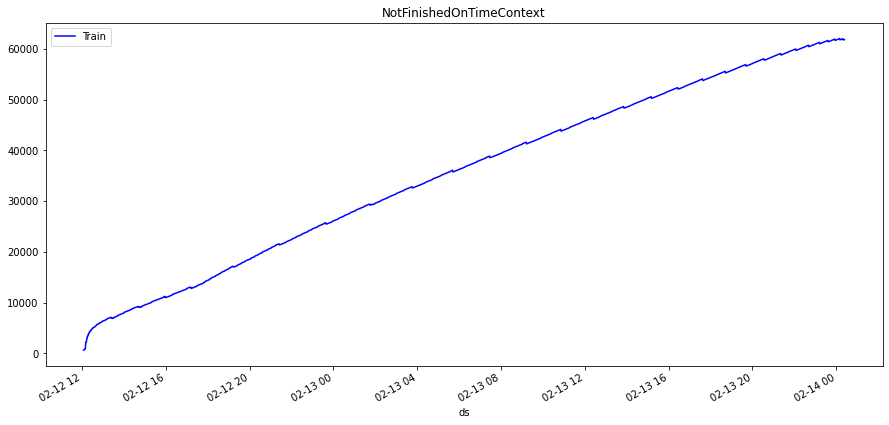

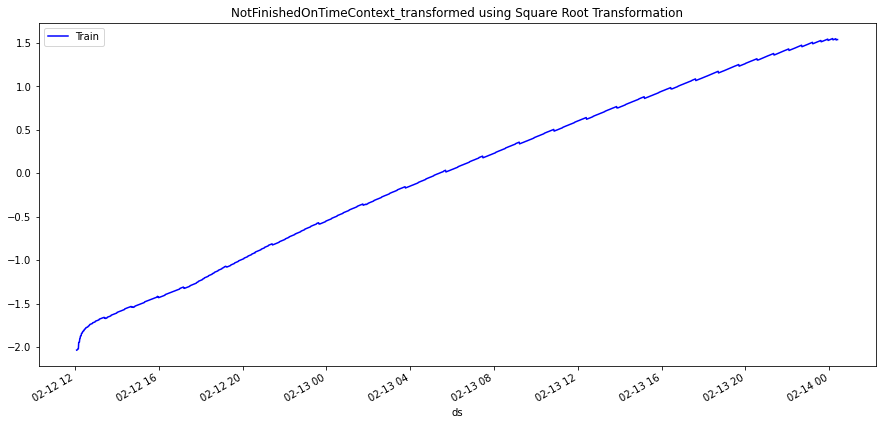

In [6]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
gluon_dataset_copy['y_orig']=gluon_dataset_copy['y']
data = array(gluon_dataset_copy['y']).reshape(len(gluon_dataset_copy['y']), 1)
transformer.fit(data)
transformed = transformer.transform(data)
gluon_dataset_copy['y']=transformed


#transformed = cube_root_transformation(gluon_dataset_copy['y'])
#gluon_dataset_copy['y']=transformed

#plot before transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y_orig', color='blue', label='Train', ax=ax)
plt.title(filename)
plt.show()

#plot after transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
#test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title(filename + "_transformed using Square Root Transformation")
plt.show()

In [7]:
gluon_dataset_copy

ds         y     y_orig
0    2021-02-12 12:04:17.490 -2.034948    630.500
1    2021-02-12 12:05:17.490 -2.033468    655.875
2    2021-02-12 12:06:17.490 -2.031717    685.875
3    2021-02-12 12:07:17.490 -2.023688    823.500
4    2021-02-12 12:08:17.490 -2.021937    853.500
...                      ...       ...        ...
2176 2021-02-14 00:20:17.490  1.533190  61787.000
2177 2021-02-14 00:21:17.490  1.534941  61817.000
2178 2021-02-14 00:22:17.490  1.536691  61847.000
2179 2021-02-14 00:23:17.490  1.537916  61868.000
2180 2021-02-14 00:24:17.490  1.537916  61868.000

[2181 rows x 3 columns]

# Splitting Data into Training and Testing

In [8]:
gluon_dataset_copy=gluon_dataset_copy.set_index('ds')
gluon_dataset=gluon_dataset.set_index('ds')
validation_time =  "2021-02-13 18:00:00"
train_time = "2021-02-13 21:00:00"
test_time = "2021-02-14 00:24:17"
freq='1min'

In [9]:
validation_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:train_time]}],
                         freq=freq
                      )
train_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:validation_time]}],
                         freq=freq
                      )
test_ds = ListDataset([{"start":gluon_dataset_copy.index[0],
                        "target":gluon_dataset_copy.y[:test_time]}],
                        freq=freq
                     )
test_orig_ds = ListDataset([{"start":gluon_dataset.index[0],
                        "target":gluon_dataset.y[:test_time]}],
                        freq=freq
                     )

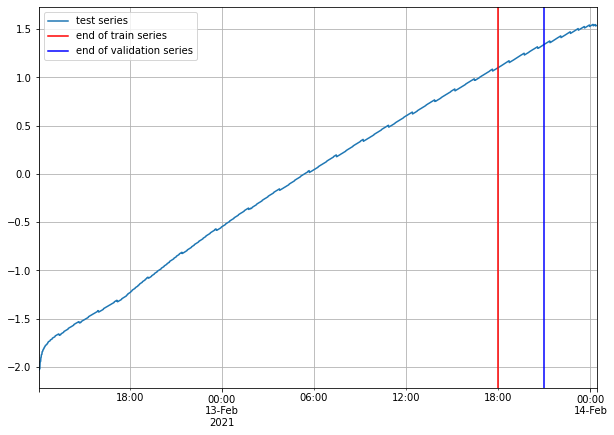

In [10]:
train_entry = next(iter(train_ds))
train_entry.keys()

validation_entry = next(iter(validation_ds))
validation_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

test_orig_entry = next(iter(test_orig_ds))
test_orig_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)
validation_series = to_pandas(validation_entry)

prediction_length = len(test_series) - len(validation_series)
context_length = [50,60]


list1=train_series.index
list2=train_entry['target']

d = {'ds':list1,'y':list2}
df_train=pd.DataFrame(d, columns=['ds','y'])

fig, ax = plt.subplots( figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(validation_series.index[-1], color='b') # end of validation dataset
ax.grid(which="both")
ax.legend(["test series", "end of train series","end of validation series"], loc="upper left")

plt.show()

In [11]:
prediction_length

205

# Hyper-parameter Tuning

In [12]:
batch_size = [75,100]
epochs = [5,10]
num_batches_per_epoch = [10,20]
learning_rate = [1e-3,1e-4]

In [13]:
from sklearn.model_selection import ParameterGrid

param_grid = {#'num_hidden_dimensions':num_hidden_dimensions,
              'batch_size': batch_size,
              'epochs': epochs,
              'num_batches_per_epoch': num_batches_per_epoch,
              'learning_rate': learning_rate,
              'context_length': context_length
             }
grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 32


In [14]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
agg_metrics_all=list()
item_metrics_all=list()
for params in all_params:
    estimator = DeepAREstimator(
                        #num_hidden_dimensions=[params['num_hidden_dimensions']],
                        prediction_length=prediction_length,
                        context_length=params['context_length'],
                        freq=freq,
                        trainer=Trainer(ctx="cpu",
                                        epochs=params['epochs'],
                                        learning_rate=params['learning_rate'],
                                        num_batches_per_epoch=params['num_batches_per_epoch']
                                       )
                )
    predictor = estimator.train(training_data = train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=validation_ds,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=20,  # number of sample paths we want for evaluation
                         )
    forecasts = list(forecast_it)
    #print(forecasts)
    tss = list(ts_it)
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    #agg_metrics['num_hidden_dimensions'] = params['num_hidden_dimensions']
    agg_metrics['epochs'] = params['epochs']
    agg_metrics['learning_rate'] = params['learning_rate']
    agg_metrics['num_batches_per_epoch'] = params['num_batches_per_epoch']
    agg_metrics['context_length'] = params['context_length']
    agg_metrics['forecast'] = forecasts
    agg_metrics_all.append(agg_metrics)
    item_metrics_all.append(item_metrics)
    
dataframe = pd.DataFrame(agg_metrics_all)
print(dataframe)
sorted1 = dataframe.sort_values(by=['MAPE'])
sorted1 = sorted1.reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


         MSE   abs_error  abs_target_sum  abs_target_mean  seasonal_error  \
0   0.218264   94.693573      247.498276         1.207309        0.002088   
1   0.113807   70.901947      247.498276         1.207309        0.002088   
2   0.494409  125.495895      247.498276         1.207309        0.002088   
3   0.091996   35.314415      247.498276         1.207309        0.002088   
4   0.007811   16.374969      247.498276         1.207309        0.002088   
5   0.004566   13.155581      247.498276         1.207309        0.002088   
6   0.082721   43.164314      247.498276         1.207309        0.002088   
7   0.739596  154.823410      247.498276         1.207309        0.002088   
8   0.374632  106.337463      247.498276         1.207309        0.002088   
9   0.046561   39.049610      247.498276         1.207309        0.002088   
10  0.265545   62.698765      247.498276         1.207309        0.002088   
11  0.048468   39.400978      247.498276         1.207309        0.002088   

# Forecast and Evaluation

In [15]:
estimator = DeepAREstimator(
    #num_hidden_dimensions=[sorted1['num_hidden_dimensions'][0]],
    prediction_length=prediction_length,
    context_length=sorted1['context_length'][0],
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=sorted1['epochs'][0],
                    learning_rate=learning_rate[0],
                    num_batches_per_epoch=sorted1['num_batches_per_epoch'][0]
                   )
)

In [16]:
predictor = estimator.train(train_ds)

  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 10/10 [00:02<00:00,  3.81it/s, epoch=10/10, avg_epoch_loss=-2.28]


# Save the Model 

In [17]:
from pathlib import Path
predictor.serialize(Path("Models/Standardization"))

# loads it back
# from gluonts.model.predictor import Predictor
# predictor_deserialized = Predictor.deserialize(Path("Models/CubeRoot"))
# print(predictor_deserialized)

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

forecasts_val=sorted1['forecast'][0]
forecast_entry_val = forecasts_val[0]



In [19]:
#return forecast to original
#inv = np.vectorize(log_inverse_transformation)

forecast_entry.samples=transformer.inverse_transform(forecast_entry.samples)
#forecast_entry.samples = inv(forecast_entry.samples)
forecast_entry_inv=SampleForecast(freq=freq, start_date=forecast_entry.start_date, samples=forecast_entry.samples)

forecast_entry_val.samples = transformer.inverse_transform(forecast_entry_val.samples)
forecast_entry_val_inv=SampleForecast(freq=freq, start_date=forecast_entry_val.start_date, samples=forecast_entry_val.samples)

ts_entry_inv=transformer.inverse_transform(ts_entry)
ts_entry_inv_df=pd.DataFrame(ts_entry_inv, index=ts_entry.index)
tss_inv=list()
tss_inv.append(ts_entry_inv_df)

In [20]:
tss_inv

[                                0
 2021-02-12 12:04:00    630.499207
 2021-02-12 12:05:00    655.874207
 2021-02-12 12:06:00    685.874207
 2021-02-12 12:07:00    823.499207
 2021-02-12 12:08:00    853.503113
 ...                           ...
 2021-02-14 00:20:00  61787.000000
 2021-02-14 00:21:00  61817.000000
 2021-02-14 00:22:00  61847.000000
 2021-02-14 00:23:00  61868.000000
 2021-02-14 00:24:00  61868.000000
 
 [2181 rows x 1 columns]]

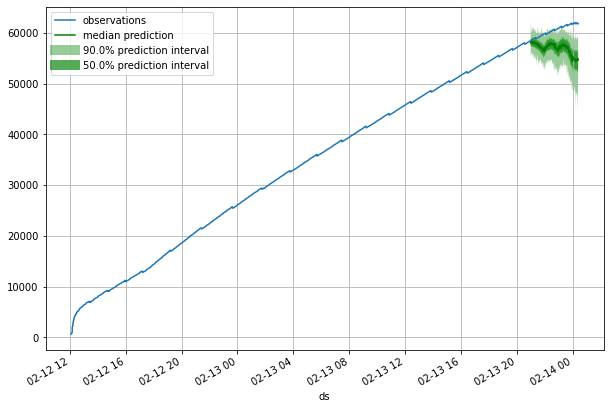

In [21]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = len(ts_entry)
    prediction_intervals = (50.0,90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(gluon_dataset['y'], forecast_entry_inv)

In [22]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss_inv), iter([forecast_entry_inv]), num_series=len(test_ds))


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


In [23]:
agg_metrics

{'MSE': 18309854.282926828,
 'abs_error': 719688.3125,
 'abs_target_sum': 12403752.0,
 'abs_target_mean': 60506.10731707317,
 'seasonal_error': 35.61948971518987,
 'MASE': 98.56049941178213,
 'MAPE': 0.05752483503990904,
 'sMAPE': 0.05975105485105024,
 'OWA': nan,
 'MSIS': 652.8129975916637,
 'QuantileLoss[0.1]': 256736.80078125,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.5]': 719688.25390625,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.9]': 482444.309375,
 'Coverage[0.9]': 0.2097560975609756,
 'RMSE': 4279.001552106149,
 'NRMSE': 0.0707201593664369,
 'ND': 0.05802182375945601,
 'wQuantileLoss[0.1]': 0.020698317797812307,
 'wQuantileLoss[0.5]': 0.05802181903558294,
 'wQuantileLoss[0.9]': 0.038895030259795585,
 'mean_absolute_QuantileLoss': 486289.78802083334,
 'mean_wQuantileLoss': 0.03920505569773028,
 'MAE_Coverage': 0.43008130081300816}

# Residual

In [24]:
#get the mean for all the samples
f1 = forecast_entry_val_inv.samples.mean(axis=0)
f2 = forecast_entry_inv.samples.mean(axis=0)

In [25]:
original_values=list(gluon_dataset['y'])
orig_test = original_values[:len(original_values)-prediction_length]
test_extract=original_values[-prediction_length:]
val_extract=orig_test[-prediction_length:]

In [26]:
valandtest_orig=list()
valandtest_pred=list()
for a1 in val_extract:
    valandtest_orig.append(a1)

for b1 in test_extract:
    valandtest_orig.append(b1)
    
for a2 in f1:
    valandtest_pred.append(a2)

for b2 in f2:
    valandtest_pred.append(b2)


Text(0.5, 1.0, 'Residuals')

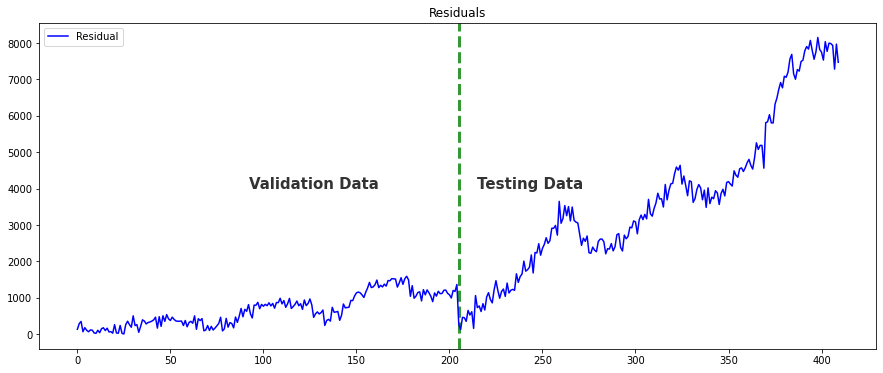

In [29]:
residuals = abs(np.array(valandtest_pred)-np.array(valandtest_orig))
residuals_df=pd.DataFrame()
residuals_df['residuals']=residuals
#residuals_df['ds']=prophet_dataset2['ds']

f, ax = plt.subplots(figsize=(15,7))
ax.text(x=len(val_extract)/2 -10,y=4000, s='Validation Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.text(x=len(val_extract)+10,y=4000, s='Testing Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.axvline(x=len(val_extract), c='green', lw=3, alpha=0.8, ls='--')
residuals_df.plot(kind='line',  y='residuals', color='blue', label='Residual',figsize=(15, 6),ax=ax)
plt.title("Residuals")

# Save the Predictions

In [28]:
predictions_df=pd.DataFrame()
predictions_df['original'] = valandtest_orig
predictions_df['predictions'] = valandtest_pred
predictions_df.to_csv(Path("Predictions/Standardization.csv"),index=False)